/opt/anaconda3/envs/pref_lern/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Train Loss: 0.0593, Val Loss: 0.0581
Epoch 2/30, Train Loss: 0.0585, Val Loss: 0.0592
Epoch 3/30, Train Loss: 0.0582, Val Loss: 0.0576
Epoch 4/30, Train Loss: 0.0581, Val Loss: 0.0593
Epoch 5/30, Train Loss: 0.0580, Val Loss: 0.0574
Epoch 6/30, Train Loss: 0.0580, Val Loss: 0.0573
Epoch 7/30, Train Loss: 0.0580, Val Loss: 0.0578
Epoch 8/30, Train Loss: 0.0580, Val Loss: 0.0571
Epoch 9/30, Train Loss: 0.0580, Val Loss: 0.0577
Epoch 10/30, Train Loss: 0.0580, Val Loss: 0.0575
Epoch 11/30, Train Loss: 0.0579, Val Loss: 0.0579
Epoch 12/30, Train Loss: 0.0579, Val Loss: 0.0574
Epoch 13/30, Train Loss: 0.0576, Val Loss: 0.0574
Epoch 14/30, Train Loss: 0.0576, Val Loss: 0.0572
Epoch 15/30, Train Loss: 0.0576, Val Loss: 0.0571
Epoch 16/30, Train Loss: 0.0576, Val Loss: 0.0575
Epoch 17/30, Train Loss: 0.0574, Val Loss: 0.0570
Epoch 18/30, Train Loss: 0.0574, Val Loss: 0.0570
Epoch 19/30, Train Loss: 0.0574, Val Loss: 0.0570
Epoch 20/30, Train Loss: 0.0574, Val Loss: 0.0571
Epoch 21/

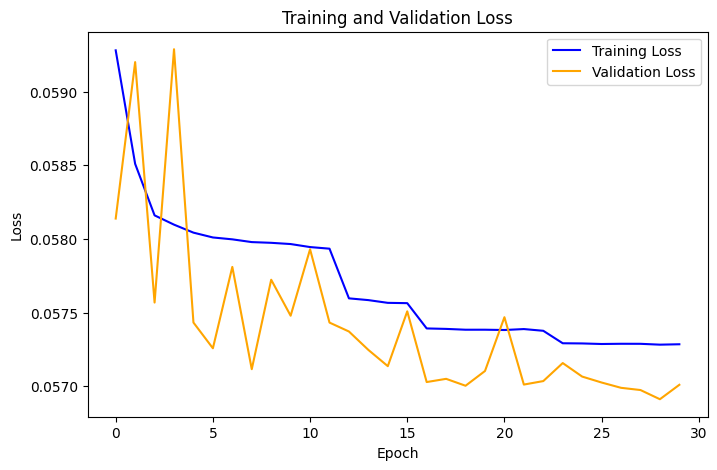

Test accuracy: 0.9754
Training completed and model saved!


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Set device to MPS for Mac users, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load the preference dataset
df_preferences = pd.read_csv("../tests/preferences.csv")

# --- Split the dataset into train (90%), val (5%), and test (5%) ---
train_df = df_preferences.sample(frac=0.90, random_state=42)
temp_df = df_preferences.drop(train_df.index)
val_df = temp_df.sample(frac=0.50, random_state=42)
test_df = temp_df.drop(val_df.index)

# Define the Preference Dataset class
class PreferenceDataset(Dataset):
    def __init__(self, df):
        self.x_better = df[["x_better", "y_better"]].values
        self.x_worse = df[["x_worse", "y_worse"]].values
        self.labels = df["preference"].values
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.x_better[idx], dtype=torch.float32),
            torch.tensor(self.x_worse[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

# Define the Policy Network with configurable depth, hidden size, and dropout
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=2, dropout_prob=0.0):
        super(PolicyNetwork, self).__init__()
        
        layers = []
        
        # Primo strato
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # Aggiunta del dropout se dropout_prob > 0
        if dropout_prob > 0:
            layers.append(nn.Dropout(dropout_prob))
        
        # Strati intermedi
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        
        # Strato di output
        layers.append(nn.Linear(hidden_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# DPO loss function
def dpo_loss(model, x_better, x_worse):
    r_better = model(x_better)
    r_worse = model(x_worse)
    return -torch.mean(torch.log(torch.sigmoid(r_better - r_worse)))

# Training parameters
batch_size = 64
epochs = 30
learning_rate = 1e-2
hidden_dim = 32
num_layers = 2
dropout_prob = 0.0

# Create Dataset objects for train, val, and test
train_dataset = PreferenceDataset(train_df)
val_dataset = PreferenceDataset(val_df)
test_dataset = PreferenceDataset(test_df)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and scheduler
model = PolicyNetwork(
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout_prob=dropout_prob
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Lists to store losses per epoch
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    epoch_train_loss = 0.0
    for x_better, x_worse, _ in train_dataloader:
        x_better, x_worse = x_better.to(device), x_worse.to(device)
        optimizer.zero_grad()
        loss = dpo_loss(model, x_better, x_worse)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_better, x_worse, _ in val_dataloader:
            x_better, x_worse = x_better.to(device), x_worse.to(device)
            loss = dpo_loss(model, x_better, x_worse)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Step the scheduler with the validation loss
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

# --- Plot losses ---
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Test Phase: compute accuracy on test set ---
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_better, x_worse, _ in test_dataloader:
        x_better, x_worse = x_better.to(device), x_worse.to(device)
        r_better = model(x_better)
        r_worse = model(x_worse)
        # We consider the prediction correct if r_better > r_worse
        correct += torch.sum(r_better > r_worse).item()
        total += x_better.size(0)

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), "dpo_policy.pth")
print("Training completed and model saved!")
